# Experiment Results for UMLP & UCNN & URNN
This notebook analyses / plots the results for the Unification MLP, Unification CNN and Unification RNN networks. For these networks we are interested if and how enabling unification affects the performance of the upstream network. In each case, the networks are compared against their plain counterparts.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Disable scientific printing
np.set_printoptions(suppress=True, precision=3, linewidth=180)

Let's accumulate the data into a csv from raw log files. Each experiment run logs to its own `*_log.json` file which is an array of dictionaries. Each entry contains the iteration and the metrics recorded at that iteration. For efficiency purposes we log every 10 iterations.

In [2]:
%%bash
for type in umlp ucnn urnn; do
  python3 utils/process_logs.py results/"$type"_result/*_log.json > results/"$type"_results.csv
done

In [3]:
# Some utility functions
def filter_by_dict(dataframe, filter_dict):
    """Filters dataframe to match keys and values of the filter_dict."""
    return dataframe.loc[(dataframe[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]

In [4]:
# Load respective data
df_umlp = pd.read_csv("results/umlp_results.csv")
# UMLP has an extra length column which is fixed and we don't need
df_umlp = df_umlp.drop(columns=['length', 'symbols'])
df_umlp['type'] = 'mlp'
df_ucnn = pd.read_csv("results/ucnn_results.csv")
df_ucnn = df_ucnn.drop(columns=['symbols'])
df_ucnn['type'] = 'cnn'
df_urnn = pd.read_csv("results/urnn_results.csv")
df_urnn = df_urnn.drop(columns=['length'])
df_urnn['type'] = 'rnn'
df = pd.concat([df_umlp, df_ucnn, df_urnn])

# The dataframe contain the training results at each iteration with experiment details
df.sample(5)

,batch_size,elapsed_time,embed,epoch,foldid,invariants,iteration,learning_rate,main/igacc,main/igloss,...,nouni,test/main/igacc,test/main/igloss,test/main/oacc,test/main/oloss,test/main/uacc,test/main/uloss,test/main/vloss,train_size,type
27472,64,115.838671,16,233,2,3,730,0.0001,1.0,0.115635,...,False,1.0,0.113888,0.307822,2.340817,0.906588,0.283159,-5.672161,50,mlp
8111,64,371.864163,16,716,0,3,1120,0.0010,1.0,0.014997,...,False,1.0,0.006655,0.763573,1.141280,0.913668,0.630998,0.211339,50,rnn
1671,64,64.059477,16,16,3,1,720,0.0010,1.0,0.222836,...,True,1.0,0.221923,0.802951,0.491005,0.462288,2.299172,0.000000,1000,mlp
3352,64,173.505728,32,559,1,1,1530,0.0001,1.0,0.001657,...,False,1.0,0.001659,0.240000,3.287196,0.610000,1.787452,-4.184572,50,cnn
10659,64,78.183243,16,192,3,4,600,0.0010,1.0,0.010207,...,False,1.0,0.010010,0.368056,3.375168,0.939815,0.432664,-73.465302,50,mlp


In [5]:
# We'll create some extra computed columns for convenience
df['unification'] = ~df['nouni'] # Do we have unification enabled?
df['test/acc'] = df['test/main/uacc'].where(df.unification, df['test/main/oacc']) # Which test accuracy to pick?
df['test/er'] = 1-df['test/acc'] # Test error rate
df.sample(5)

,batch_size,elapsed_time,embed,epoch,foldid,invariants,iteration,learning_rate,main/igacc,main/igloss,...,test/main/oacc,test/main/oloss,test/main/uacc,test/main/uloss,test/main/vloss,train_size,type,unification,test/acc,test/er
21147,64,161.376559,32,538,0,1,1480,0.0100,1.0,0.000006,...,0.342500,5.551575,0.166563,5.683672,0.000000,50,cnn,False,0.342500,0.657500
16106,64,175.147381,32,31,0,3,1070,0.0010,1.0,0.000612,...,0.297188,5.195882,0.993750,0.029166,-103.027107,1000,cnn,True,0.993750,0.006250
27668,64,223.130117,16,441,3,3,690,0.0001,1.0,0.324074,...,0.799400,0.522974,0.865215,0.342947,0.379689,50,rnn,True,0.865215,0.134785
15279,64,237.595167,16,512,1,1,800,0.0100,1.0,0.005455,...,0.831124,0.929968,0.811237,0.990822,0.338147,50,rnn,True,0.811237,0.188763
11704,64,114.940348,16,336,3,1,1050,0.0001,0.5,0.930857,...,0.550781,1.228529,0.442612,1.749470,0.000000,50,mlp,False,0.550781,0.449219


## Does unification help with generalisation?
We will plot the test accuracy over iterations to see if unification helps with generalisation. We will take a single invariant case. Note that the baselines also have a single invariant although it is not used. We use it to check if training the baseline for some reason also improves unification haphazardly.

In [6]:
# Filter data to get single invariants
df1 = df[(df.invariants == 1)]

# Adjust column names and types for plotting
df1 = df1.assign(type=df1['type'].str.upper(), unification=np.where(df1.unification, 'Yes', 'No'),
                 train_size=np.where((df1.train_size == 0) | (df1.train_size == 1000), '≤ 1000', '≤ 50'))
df1 = df1.rename(columns={'unification': 'Unification', 'train_size': 'Training Size'})
df1.sample(5)

,batch_size,elapsed_time,embed,epoch,foldid,invariants,iteration,learning_rate,main/igacc,main/igloss,...,test/main/oacc,test/main/oloss,test/main/uacc,test/main/uloss,test/main/vloss,Training Size,type,Unification,test/acc,test/er
12199,64,230.428919,32,58,0,1,2000,0.0010,1.000,0.000822,...,0.259688,16.745154,1.000000,0.004580,-60.481030,≤ 1000,CNN,Yes,1.000000,0.000000
11487,64,95.704795,16,281,2,1,880,0.0001,0.825,0.699143,...,0.516445,1.270437,0.413628,2.025318,0.000000,≤ 50,MLP,No,0.516445,0.483555
346,64,375.077067,16,47,1,1,1470,0.0001,1.000,0.194504,...,0.921402,0.265171,0.832860,0.365998,0.492886,≤ 1000,RNN,No,0.921402,0.078598
2967,64,437.031120,16,1075,4,1,1680,0.0010,1.000,0.002559,...,0.809943,1.311615,0.485471,4.139308,0.481807,≤ 50,RNN,No,0.809943,0.190057
12449,64,45.603295,16,11,2,1,500,0.0100,1.000,0.009823,...,0.978684,0.075542,0.523438,3.493923,0.000000,≤ 1000,MLP,No,0.978684,0.021316


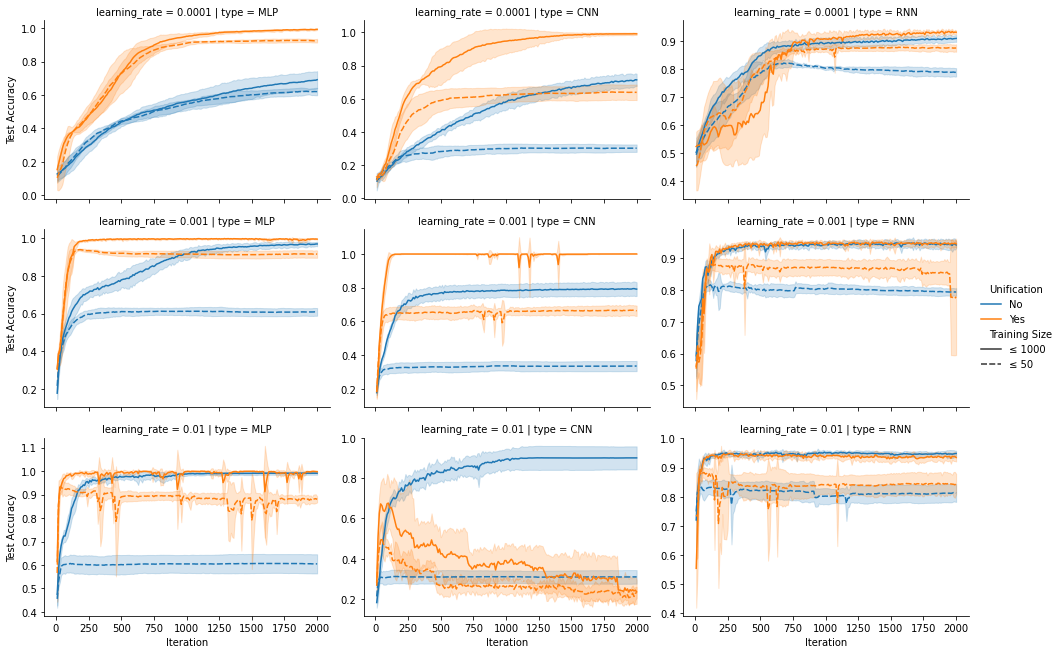

In [7]:
# Plot the test accuracy
g = sns.relplot(x='iteration', y='test/acc', hue='Unification',
                style='Training Size', kind='line', col='type', row='learning_rate', ci='sd',
                height=3, aspect=1.5, facet_kws={'sharey': False}, data=df1)
#g.set_titles("{col_name}")
g.set_ylabels("Test Accuracy")
g.set_xlabels("Iteration")
g.savefig("results/umlp_ucnn_urnn_acc_plot.pdf", bbox_inches='tight')

# How correct are the learnt invariants?
For the synthetic datasets, we can check if the models recognise the correct symbols as variables. Here we are looking for **strict exact match** to the desired invariant. For example, if it is to predict the head of the sequence, we will compare the thresholded variable map to `V _ _ _`. Note that the models may still solve the tasks if they are using more or less variables than the exact desired number.

In [8]:
# Let's look at UMLP and the sequences dataset.
def correct_umlp_invs(train_size=1000):
    """Analyse the number of correct invariants identified by UMLP in the sequences dataset."""
    params = {'type': 'mlp',
              'unification': True,
              'train_size': train_size,
              'invariants': 1, # With multiple invariants, the model could be using a mixture so we'll focus in single invariant case.
              'learning_rate': 0.001}
    dfi1 = filter_by_dict(df, params)
    exp_names = dfi1.name.unique()
    assert len(exp_names) % 5 == 0, "Unexpected number of runs for 5-fold cross validation."
    correct_count = 0
    for exp_name in exp_names:
        with open(f"results/umlp_result/{exp_name}.out") as f:
            exp_out = [l.strip() for l in f.readlines() if l.strip()] # These are debug text files
        # Extract out the invariant examples, to find out which symbols should be variables
        start_line = exp_out.index('---- INVS ----') + 1
        invariant_examples = exp_out[start_line:start_line + 4]
        invariant_examples = np.array([re.findall(r'\d', line) for line in invariant_examples]).astype(int) # (num_task, 1+L+1)
        correct_inv_symbols = invariant_examples[:, -1] # (num_task,) the answers to the task should be the varying symbols
        # Note that task 1, predict constant, nothing should be a variable
        # ---
        # Extract the variable map from the output file
        start_line = exp_out.index('---- SAMPLE ----') - 4
        vmaps = exp_out[start_line:start_line + 4]
        vmaps = np.array([re.findall(r'\d\.\d*', line) for line in vmaps]).astype(float) # (num_task, V)
        # ---
        # Check if only those symbols are recognised as variables
        expected = np.eye(vmaps.shape[1], dtype=bool) # (V, V)
        expected = expected[correct_inv_symbols] # (num_tasks, V)
        expected[0] = False # For constant task, there should be no variables
        threshold = np.nanmean(np.where(vmaps[1:] > 0.001, vmaps[1:], np.nan), -1, keepdims=True) - 0.001 # (num_tasks-1, 1) mean of variable symbols used as a heuristic
        threshold = np.insert(threshold, 0, [[0.001]], axis=0) # Threshold for constant task
        is_correct = np.all(expected == (vmaps > threshold), -1).sum() # It would be 4 if all tasks are correctly lifted into invariants
        correct_count += is_correct
    params.update({'correct_count': correct_count, 'total': len(exp_names) * vmaps.shape[0]})
    return params
umlp_correct = pd.DataFrame([correct_umlp_invs(t) for t in [1000, 50]])
umlp_correct

,type,unification,train_size,invariants,learning_rate,correct_count,total
0,mlp,True,1000,1,0.001,18,20
1,mlp,True,50,1,0.001,18,20


In [9]:
# Let's look at UCNN and the grid dataset.
def correct_ucnn_invs(train_size=1000):
    """Analyse the number of correct invariants identified by UCNN in the grid dataset."""
    params = {'type': 'cnn',
              'unification': True,
              'train_size': train_size,
              'invariants': 1, # With multiple invariants, the model could be using a mixture so we'll focus in single invariant case.
              'learning_rate': 0.001}
    dfi1 = filter_by_dict(df, params)
    exp_names = dfi1.name.unique()
    assert len(exp_names) % 5 == 0, "Unexpected number of runs for 5-fold cross validation."
    correct_count = 0
    for exp_name in exp_names:
        with open(f"results/ucnn_result/{exp_name}.out") as f:
            exp_out = [l.strip() for l in f.readlines() if l.strip()] # These are debug text files
        # Extract out the invariant example answers, the answer symbols are the ones that should vary
        vmap_idxs = [i for i, l in enumerate(exp_out) if l == 'Vmap:']
        assert len(vmap_idxs) == 4, "Unexpected number of invariants, there should 1 per task, total 4."
        correct_inv_symbols = np.array([int(exp_out[i-1][-1]) for i in vmap_idxs]) # (num_task,) the answers to the task should be the varying symbols
        # ---
        # Extract the variable map from the output file
        vmaps = np.array([re.findall(r'\d\.\d*', exp_out[i+1]) for i in vmap_idxs]).astype(float) # (num_task, V)
        # ---
        # Check if only those symbols are recognised as variables
        expected = np.eye(vmaps.shape[1], dtype=bool) # (V, V)
        expected = expected[correct_inv_symbols] # (num_tasks, V)
        threshold = np.nanmean(np.where(vmaps > 0.001, vmaps, np.nan), -1, keepdims=True) - 0.001 # (num_tasks, 1) mean of variable symbols used as a heuristic
        is_correct = np.all(expected == (vmaps > threshold), -1).sum() # It would be 4 if all tasks are correctly lifted into invariants
        correct_count += is_correct
    params.update({'correct_count': correct_count, 'total': len(exp_names) * vmaps.shape[0]})
    return params
ucnn_correct = pd.DataFrame([correct_ucnn_invs(t) for t in [1000, 50]])
ucnn_correct

,type,unification,train_size,invariants,learning_rate,correct_count,total
0,cnn,True,1000,1,0.001,13,20
1,cnn,True,50,1,0.001,14,20


In [10]:
umlp_ucnn_correct = pd.concat([umlp_correct, ucnn_correct])
umlp_ucnn_correct.assign(accuracy=(umlp_ucnn_correct.correct_count / umlp_ucnn_correct.total*100))

,type,unification,train_size,invariants,learning_rate,correct_count,total,accuracy
0,mlp,True,1000,1,0.001,18,20,90.0
1,mlp,True,50,1,0.001,18,20,90.0
0,cnn,True,1000,1,0.001,13,20,65.0
1,cnn,True,50,1,0.001,14,20,70.0


## What's best result for each model type?
We will pick the best learning rate for each model type with and without unification for every dataset for the final comparison. This comparision does not paint a full picture since there are many other hyper-parameters one can tune to squeeze every ounce performance from unification vs non-unification models. Hence, we leave this plot as a reference code sample.

In [11]:
# We'll take the mean of last iterations to determine the convergence point
df_tail = df1[(df1.iteration > 1950)]
#dff.groupby(by=['type', 'Training Size', 'Unification', 'learning_rate'])['test/acc'].mean()
df_conv = pd.pivot_table(df_tail, index=['type', 'Training Size', 'Unification'], columns=['learning_rate'], values=['test/acc'], aggfunc={'test/acc': np.mean})
df_conv

test/acc                    
learning_rate                     0.0001    0.0010    0.0100
type Training Size Unification                              
CNN  ≤ 1000        No           0.711392  0.792752  0.900596
                   Yes          0.991625  1.000000  0.241862
     ≤ 50          No           0.302005  0.334707  0.310332
                   Yes          0.639123  0.664783  0.224846
MLP  ≤ 1000        No           0.688445  0.968437  0.990975
                   Yes          0.992099  0.996074  0.998490
     ≤ 50          No           0.620272  0.609391  0.604847
                   Yes          0.924802  0.916156  0.879951
RNN  ≤ 1000        No           0.908849  0.943156  0.947015
                   Yes          0.931852  0.946347  0.935936
     ≤ 50          No           0.788801  0.794232  0.812810
                   Yes          0.875580  0.776363  0.842783

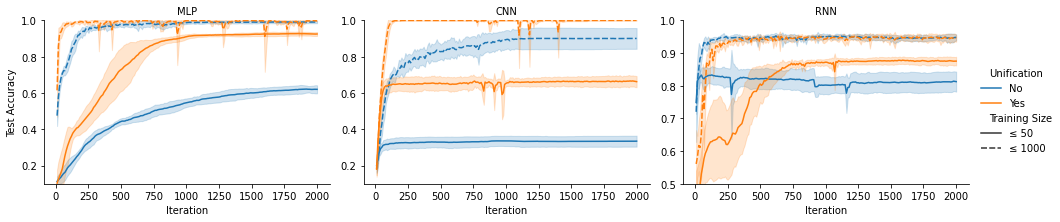

In [12]:
# Obtain best learning rate
df_best = df_conv['test/acc'].T.idxmax()
# Filter based on the best learning rate
best_filter = False
for ((mtype, tsize, uni), lrate) in zip(df_best.index.tolist(), df_best.values):
    best_filter |= ((df1.type == mtype) & (df1['Training Size'] == tsize) & (df1['Unification'] == uni) & (df1.learning_rate == lrate))
df_best = df1[best_filter]
# Plot the test accuracy
g = sns.relplot(x='iteration', y='test/acc', hue='Unification',
                style='Training Size', kind='line', col='type', ci='sd',
                height=3, aspect=1.5, facet_kws={'sharey': False, 'ylim': (0.1, 1.0)}, data=df_best)
g.set_titles("{col_name}")
g.set_ylabels("Test Accuracy")
g.facet_axis(0, 2).set_ylim(0.5, 1.0)
g.set_xlabels("Iteration")
g.savefig("results/umlp_ucnn_urnn_acc_best_plot.pdf", bbox_inches='tight')

## What is the effect of having more invariants?
We are now interested in increasing the number of invariants and looking at the change in performance. Since the tasks can be solved with a single invariant already, is there performance benefit of using multiple? It is important to note that there is a sparsity constraint on the magnitude of the variables, hence we expect the change to minimal if any for these models in which we aggregate the invariant predictions by summing them up.

In [13]:
# Let's take only the unification cases
dfu = df[df.unification]

# Fix column names etc. for plotting
dfu = dfu.assign(type=dfu['type'].str.upper(), train_size=np.where((dfu.train_size == 0) | (dfu.train_size == 1000), '≤ 1000', '≤ 50'))
dfu = dfu.rename(columns={'train_size': 'Training Size'})

dfu.sample(5)

,batch_size,elapsed_time,embed,epoch,foldid,invariants,iteration,learning_rate,main/igacc,main/igloss,...,test/main/oacc,test/main/oloss,test/main/uacc,test/main/uloss,test/main/vloss,Training Size,type,unification,test/acc,test/er
22106,64,115.007488,32,31,0,1,1070,0.010,1.0,0.159300,...,0.230313,5.221132,0.452188,1.579708,-305.175415,≤ 1000,CNN,True,0.452188,0.547812
6883,64,105.325098,16,268,4,2,840,0.001,1.0,0.005094,...,0.467930,3.032316,0.899450,0.589434,-50.925980,≤ 50,MLP,True,0.899450,0.100550
7149,64,475.933941,16,48,0,3,1500,0.001,1.0,0.097031,...,0.930556,0.219684,0.945549,0.372582,0.298608,≤ 1000,RNN,True,0.945549,0.054451
12431,64,36.027006,32,9,2,1,320,0.001,1.0,0.002444,...,0.272035,3.439322,1.000000,0.007750,-8.271679,≤ 1000,CNN,True,1.000000,0.000000
17254,64,90.764308,32,201,1,3,550,0.001,1.0,0.000824,...,0.285000,5.384274,0.617500,2.477866,-53.064503,≤ 50,CNN,True,0.617500,0.382500


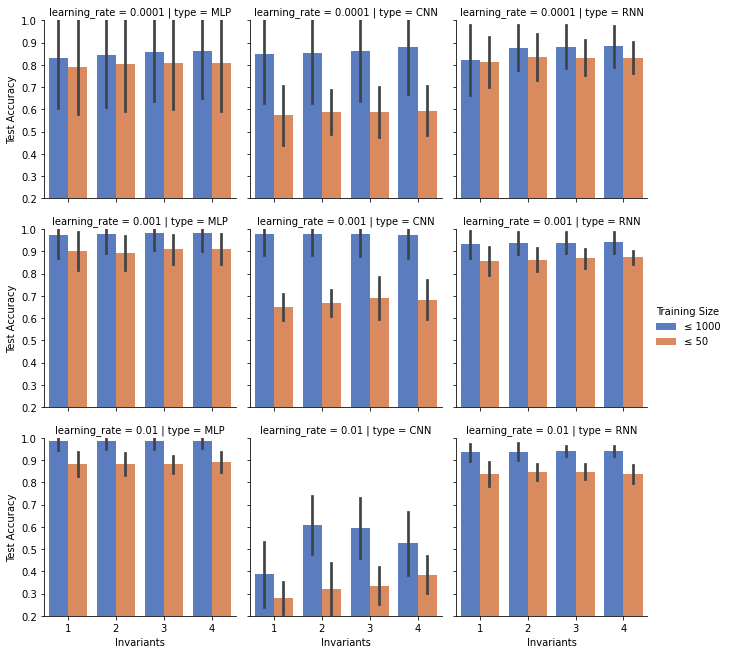

In [14]:
# Plot the test accuracy
g = sns.catplot(x='invariants', y='test/acc', hue='Training Size', height=3,
                col='type', row='learning_rate', kind='bar', ci='sd', data=dfu, palette='muted')
#g.set_titles("{col_name}")
g.set_ylabels("Test Accuracy")
g.set_xlabels("Invariants")
plt.ylim(0.2, 1.0)
g.savefig("results/umlp_ucnn_urnn_invs_plot.pdf", bbox_inches='tight')

# Visualising an invariant
Here we take an invariant from the sentiment analysis task and visualise the variableness of each of the symbols in the sentence. Due to the sparsity constraint on the variableness of symbols, we expect these values to be very low if not zero. They represent by how much each symbol should / could be interpolated to let the upstream network predict correctly.

In [15]:
params = {'type': 'rnn',
          'unification': True,
          'train_size': 50, # 50 or 1000
          'invariants': 1, # With multiple invariants, the model could be using a mixture so we'll focus in single invariant case.
          'learning_rate': 0.001}
df_urnn = filter_by_dict(df, params)
exp_names = df_urnn.name.unique()
exp_name = exp_names[0] # Pick one, these are the different runs, 1 per fold.
with open(f"results/urnn_result/{exp_name}.out", 'r') as f:
    outs = f.read().splitlines() # Gets without trailing \n
# Find and get invariant
inv_str = outs[outs.index('Inv:') + 1].split(' -> ')
inv = eval(inv_str[0]) # ['vivid', 'with', ...]
label = int(inv_str[1]) # 1 for positive 0 for negative
# Find and get vmap
vmap = np.array(eval(re.sub('\s+', ',', outs[outs.index('vmap:') + 1].strip()[1:-1])))
# Combine them
inv_map = pd.DataFrame({'Symbol': inv, 'Variableness': vmap})

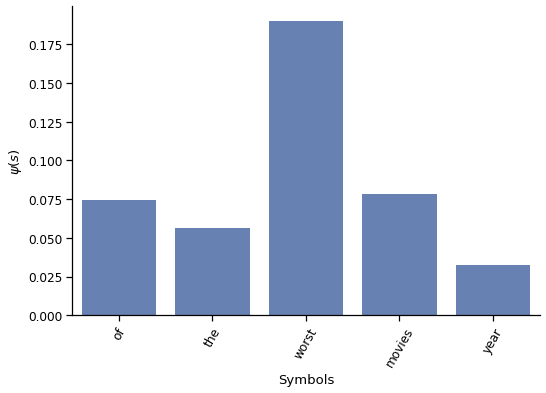

In [16]:
# Plot the vmap
sns.set_context("notebook", font_scale=1.1)
g = sns.catplot(x='Symbol', y='Variableness', kind='bar', data=inv_map, color='#597dbf', aspect=1.5)
#g.set_titles("Variable Map")
g.set_ylabels("$\psi(s)$")
g.set_xlabels("Symbols")
plt.xticks(rotation=60)
g.savefig("results/sentiment_inv.pdf", bbox_inches='tight')